In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
while not os.getcwd().endswith('Laboratorio_SiPM'):
    os.chdir('..')

import sys
sys.path.append('Config')
from lablib import *

# Ladder

In [75]:
def invert (X):
    for i in range(len(X)):
        X[i] = - X[i]
    return X

In [76]:
def graph(X1, Y1, X2, Y2, X3, Y3, X4, Y4, X5, Y5, X6, Y6):
    plt.figure(figsize=(10, 6))
    
    fig, ax = plt.subplots(nrows= 1, ncols=1)
    plt.plot(invert(X1), Y1, label='53.5mV', linewidth=0.8)
    ax.scatter(X1, Y1)

    plt.plot(invert(X2), Y2, label='54mV', linewidth=0.8)
    ax.scatter(X2, Y2)

    plt.plot(invert(X3), Y3, label='54.5mV',linewidth=0.8)
    ax.scatter(X3, Y3)
    
    plt.plot(invert(X5), Y5, label='55mV',linewidth=0.8)
    ax.scatter(X5, Y5)
    
    plt.plot(invert(X6), Y6, label='55.5mV',linewidth=0.8)
    ax.scatter(X6, Y6)

    ax.set_yscale ("log")
    ax.set_xlabel("Threshold[mV]")
    ax.set_ylabel("Log(Frequency[kHz])")
    ax.legend()
    plt.grid()
    plt.savefig("Staircase_Finale.png")
    plt.show()
   

In [77]:
def cut_0(X, Y):
    X1 = []
    Y1 = []
    for i in range(len(X)):
        if X[i] != 0:
            X1.append(X[i])
            Y1.append(Y[i])
    return Y1, X1

[np.float64(0.421933), np.float64(0.248167), np.float64(0.170433), np.float64(0.0392333), np.float64(0.00166667), np.float64(0.000666667), np.float64(0.000566667), np.float64(6.67e-05), np.float64(6.67e-05)]


<Figure size 1000x600 with 0 Axes>

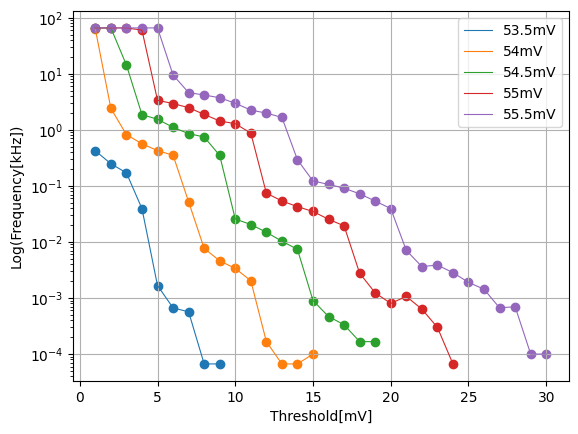

In [78]:
Z = pd.read_csv(r"Analisi/Parte 1/Analisi Dark_Ladder/staircase_plot_bello.CSV")
Y = Z["Th [mV] V_B 53_5V "]
K1 = cut_0(Z["F [kHz] V_B 53_5V"], Y)
K2 = cut_0(Z["F [kHz] V_B 54V"], Y)
K3 = cut_0(Z["F [kHz] V_B 54_5V"], Y)
K4 = cut_0(Z["F [kHz] V_B 55V"], Y)
K5 = cut_0(Z["F [kHz] V_B 55_5V"], Y)
K6 = cut_0(Z["F [kHz] V_B 56V"], Y)

print(K1[1])

graph(K1[0], K1[1], K2[0], K2[1], K3[0], K3[1], K4[0], K4[1], K5[0], K5[1], K6[0], K6[1])

# Crosstalk

In [79]:
# ct_53_5 difficilmente distinguibile

ct_54 = K2[1][10] / K2[1][5]
#err_54 = 0.35901*np.sqrt(1/K2[1][10]**2 + K2[1][10]**2/K2[1][5]**4)

ct_54_5 = K3[1][12] / K3[1][6]
#err_54_5 = 0.35901*np.sqrt(1/K3[1][12]**2 + K3[1][12]**2/K3[1][6]**4)

ct_55 = K5[1][14] / K5[1][7]
#err_55 = 0.35901*np.sqrt(1/K5[1][14]**2 + K5[1][14]**2/K5[1][7]**4)

ct_55_5 = K6[1][17] / K6[1][10]
#err_55_5 = 0.35901*np.sqrt(1/K6[1][17]**2 + K6[1][17]**2/K6[1][10]**4)


x = np.array([54, 54.5, 55, 55.5])
y = np.array([ct_54, ct_54_5, ct_55, ct_55_5])
yer = [.001 for i in range(len(x))] 
#yer = np.array([0.35901, 0.35901, 0.35901, 0.35901]) 
#yer = [err_54, err_54_5, err_55, err_55_5]

vbr = 52

In [80]:
def exp(x, a, b):
    return a * (1 - np.exp(x / b))

pars, vals, ers, *other = LS_fit(x, y, yer, exp, a=1, b=1, disp=0)

for i in range(len(pars)):
    print(f"Parameter {pars[i]}: {vals[i]:.3g} ± {ers[i]:.3g}")

c2r = other[2] / other[1]
print(f"Chi2/ndf: {c2r:.3g}")

Parameter a: -4.06e-26 ± 2.75e-32
Parameter b: 1.01 ± 1.25e-08
Chi2/ndf: 1.36


<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
C:\Users\matte\AppData\Local\Temp\ipykernel_28068\1051929954.py:4: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(t-vbr, exp(np.array(t), *vals), label='Fit, $\\tilde{\chi}^2$ = 1.4', color='red')


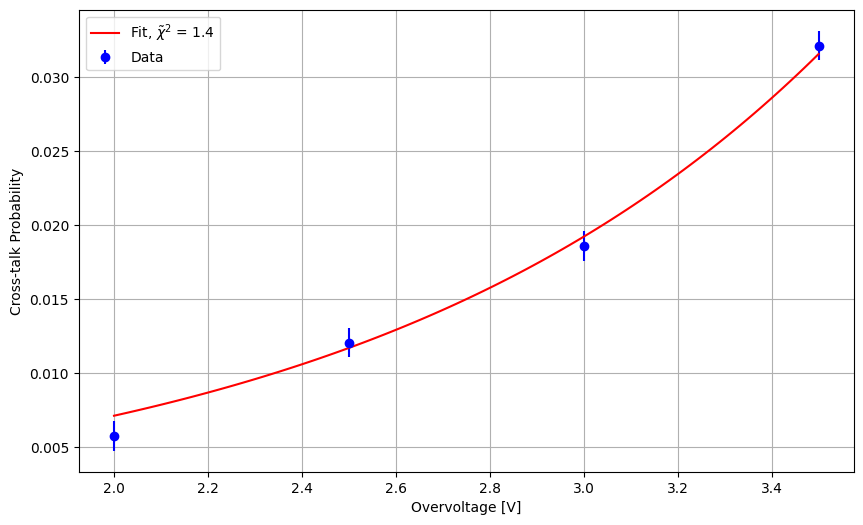

In [81]:
t = np.linspace(54, 55.5, 100)
plt.figure(figsize=(10, 6))
plt.errorbar(x-vbr, y, yerr=yer, fmt='o', label='Data', color='blue')
plt.plot(t-vbr, exp(np.array(t), *vals), label='Fit, $\\tilde{\chi}^2$ = 1.4', color='red')
plt.xlabel('Overvoltage [V]')
plt.ylabel('Cross-talk Probability')
plt.grid()
plt.legend()
plt.savefig("Cross_talk_fit.png")
plt.show()

# Save the fit parameters to a file

In [82]:
def exp_squared (x, b):
    return (1 - np.exp(-b*(x -vbr)**2 ))

pars2, vals2, ers2, *other2 = LS_fit(x, y, yer, exp_squared, b=0.0005, disp=0)

for i in range(len(pars2)):
    print(f"Parameter {pars2[i]}: {vals2[i]:.3g} ± {ers2[i]:.3g}")

c2r2 = other2[2] / other2[1]
print(f"Chi2/ndf: {c2r2:.3g}")

Parameter b: 0.00233 ± 6.05e-05
Chi2/ndf: 12.9


<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
C:\Users\matte\AppData\Local\Temp\ipykernel_28068\1152026797.py:4: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(t-vbr, exp_squared(np.array(t), *vals2), label='Fit, $\\tilde{\chi}^2$ = 1.4', color='red')


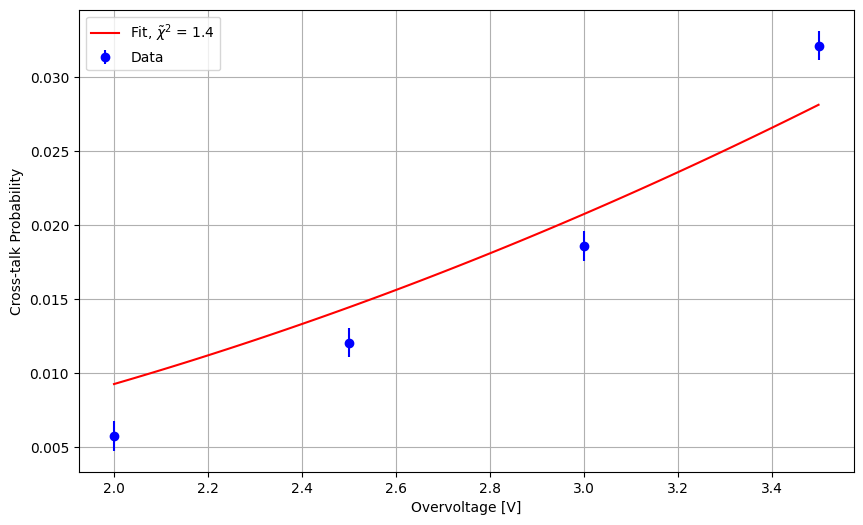

In [83]:
t = np.linspace(54, 55.5, 100)
plt.figure(figsize=(10, 6))
plt.errorbar(x-vbr, y, yerr=yer, fmt='o', label='Data', color='blue')
plt.plot(t-vbr, exp_squared(np.array(t), *vals2), label='Fit, $\\tilde{\chi}^2$ = 1.4', color='red')
plt.xlabel('Overvoltage [V]')
plt.ylabel('Cross-talk Probability')
plt.grid()
plt.legend()
#plt.savefig("Cross_talk_fit.png")
plt.show()